In [2]:
import numpy as np
import pandas as pd

import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

from scipy.stats import mannwhitneyu,wilcoxon,shapiro, levene, ttest_ind,f_oneway,kruskal

import re
import warnings
# import ('../../../utils.py')
warnings.filterwarnings('ignore')


# Utils

## Functions

### Feature Selection

In [57]:
def get_fc_dict(df,class_label,metab_num):
    df=df.copy(deep=True)
    means = df.groupby(class_label).mean()
    fold_changes = means.iloc[1] / means.iloc[0] 
    fc_dict=dict(zip(df.columns.tolist(),fold_changes))
    return fc_dict
    # 计算fold change
    fold_changes = means.iloc[1] / means.iloc[0] 
def get_pvalue_dict(df,label_cols,unwanted_cols=[]):
    
    # delete unwanted
    colnames = df.columns
    colnames = list(set(colnames)-set(label_cols)-set(unwanted_cols))
    classes=list(dict(sorted(dict(df.value_counts(label_cols[0])).items())).keys())
    print(classes)
    pvalue_dict={}
    if(len(classes)>2):
        for i,colname in enumerate(colnames):
            class_features=[]
            df=df.astype({colname:float})
            for label in classes:
                tmp_feature=[]
                # tmp_feature = df.loc[(df[label_cols[0]] == label)]
                tmp_feature = df.loc[(df[label_cols[0]] == label)].loc[:, colname].tolist()
                class_features.append(tmp_feature)

            _, p_value = kruskal(*class_features)
            pvalue_dict[colname]=p_value
    else:
        for i,colname in enumerate(colnames):
            class_features=[]
            df=df.astype({colname:float})
            for label in classes:
                tmp_feature=[]
                # tmp_feature = df.loc[(df[label_cols[0]] == label)]
                tmp_feature = df.loc[(df[label_cols[0]] == label)].loc[:, colname].tolist()
                class_features.append(tmp_feature)

            _, p_value = mannwhitneyu(*class_features)
            pvalue_dict[colname]=p_value
        
    return pvalue_dict


# Analysis

## 20240419

In [9]:
sample_df=pd.read_csv('../../Subtype/results/20240406/cluster_7e-2.csv',index_col=0)
sample_df

,nmf_3_clusters,kmeans_3_clusters,nmf_2_clusters,kmeans_2_clusters
1452,1,1,1,2
8339,1,1,1,2
5608,1,1,1,2
8232,3,3,2,1
8775,2,3,2,1
...,...,...,...,...
140143-T,1,2,1,2
190040-T,1,2,1,2
190161-T,3,2,2,2
200288-T,3,2,2,1


### RNA seq

In [4]:
rna_df=pd.read_csv('../data/rna/genes.csv',index_col=0)
print(rna_df.shape)
print(rna_df.columns)
rna_df=rna_df.reset_index().rename(columns={'cccc':'Sample Name'}).set_index('Sample Name')

# Rename columns
pattern = r"[Ca|T]([\d]+)"
new_columns=[]
for colname in rna_df.columns:
    id_string=re.search(pattern,colname).group(1)
    if 'T' in colname:
        new_colname=str(id_string)+'-T'
    else:
        new_colname=str(id_string)
    new_columns.append(new_colname)
new_columns
rna_df.rename(columns=dict(zip(rna_df.columns,new_columns)),inplace=True)
rna_df=rna_df.T
rna_df.astype(int)

print(f"data size is {rna_df.shape}")


(58818, 111)
Index(['count.Ca1277', 'count.Ca1364', 'count.Ca1452', 'count.Ca1520',
       'count.Ca1649', 'count.Ca1775', 'count.Ca1870', 'count.Ca1900',
       'count.Ca2039', 'count.Ca2139',
       ...
       'count.T200095', 'count.T200097', 'count.T200128', 'count.T200131',
       'count.T200288', 'count.T200297', 'count.T210011', 'count.T210012',
       'count.T222836', 'count.T271431'],
      dtype='object', length=111)
data size is (111, 58818)


In [5]:
counts_df=rna_df.copy(deep=True)

In [6]:
display(counts_df.head())
rna_df.dtypes

Sample Name,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288634,ENSG00000288635,ENSG00000288636,ENSG00000288637,ENSG00000288638,ENSG00000288639,ENSG00000288640,ENSG00000288642,ENSG00000288644,ENSG00000288645
1277,77,0,19,125,38,96,0,50,492,0,...,2,0,1,5,0,0,0,7,0,0
1364,1443,0,942,1420,1792,112,241,1240,1482,1638,...,1,0,0,97,191,0,0,0,1,1
1452,297,7,712,1323,1901,141,252,930,249,2249,...,1,0,0,200,393,0,142,0,1,4
1520,1102,22,841,1968,1588,2029,4576,2183,2601,3123,...,1,0,0,87,3,0,80,0,1,1
1649,531,5,998,1889,2306,296,136,483,1567,2317,...,1,3,0,257,85,0,0,0,1,1


Sample Name
ENSG00000000003    int64
ENSG00000000005    int64
ENSG00000000419    int64
ENSG00000000457    int64
ENSG00000000460    int64
                   ...  
ENSG00000288639    int64
ENSG00000288640    int64
ENSG00000288642    int64
ENSG00000288644    int64
ENSG00000288645    int64
Length: 58818, dtype: object

In [11]:
sample_indexes=list(set(rna_df.index)&set(sample_df.index))

#### Prepare Data

In [12]:
print(f"data size is {counts_df.shape}")
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]
counts_df=counts_df.loc[sample_indexes]
counts_sample_df=sample_df.loc[sample_indexes]
print(f"data size is {counts_df.shape}")

data size is (111, 55963)
data size is (92, 55963)


In [13]:
# Replace with your actual sample information (e.g., control vs. treatment)
condition_series = sample_df.loc[:,['kmeans_2_clusters']]


In [15]:
inference = DefaultInference(n_cpus=64)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=counts_sample_df,
    design_factors="kmeans_2_clusters",
    refit_cooks=True,
    inference=inference,
)
# Create a DESeq2 dataset (DESeqDataSet)


In [16]:
dds.deseq2()


Fitting size factors...
... done in 0.14 seconds.

Fitting dispersions...
... done in 6.81 seconds.

Fitting dispersion trend curve...
... done in 1.28 seconds.

Fitting MAP dispersions...
... done in 7.60 seconds.

Fitting LFCs...
... done in 5.45 seconds.

Replacing 6997 outlier genes.

Fitting dispersions...
... done in 1.12 seconds.

Fitting MAP dispersions...
... done in 1.00 seconds.

Fitting LFCs...
... done in 1.19 seconds.



In [24]:
stat_res = DeseqStats(dds, inference=inference)
stat_res.summary()

In [31]:
rna_stat_result_df=stat_res.results_df
# rna_stat_result_df.to_csv('../results/20240419/rna_stat.csv')

In [32]:
rna_sd_df=rna_stat_result_df[(abs(rna_stat_result_df['log2FoldChange'])>=1)&(rna_stat_result_df['padj']<=5e-2)]


#### Result

In [33]:
print("#Ensembl Gene logFC")
for i in rna_sd_df.index:
    print(f"{i} {rna_sd_df.loc[i,'log2FoldChange']}")

#Ensembl Gene logFC
ENSG00000000971 -1.0070714303282085
ENSG00000003400 -1.3814084048816504
ENSG00000003436 -1.2186552312392647
ENSG00000004468 -1.1417298873754904
ENSG00000004846 1.9698176007012365
ENSG00000004848 1.806965526819008
ENSG00000005001 -1.3341738766762816
ENSG00000005844 -1.215854266743688
ENSG00000006283 1.641354170204823
ENSG00000006377 1.0672546111212795
ENSG00000007129 -1.4550509444758515
ENSG00000007216 -2.190280328526158
ENSG00000007312 -1.9142300377921677
ENSG00000007372 1.5609733416738458
ENSG00000008517 -1.3344207714233003
ENSG00000009790 -1.2623882842551326
ENSG00000010295 -1.0193183231432381
ENSG00000010610 -1.1711165773426984
ENSG00000010671 -1.0031543534108092
ENSG00000010932 -1.1444974812981494
ENSG00000011332 1.25976062194913
ENSG00000012124 -1.5355826595672255
ENSG00000012223 -1.4539922022048886
ENSG00000013588 -1.6525206783291768
ENSG00000013725 -1.1825611126702347
ENSG00000014257 -1.1212809608917238
ENSG00000017427 -1.3227419911696081
ENSG00000018280 -1.4

In [ ]:
print(dds)


AnnData object with n_obs × n_vars = 92 × 55559
    obs: 'nmf_3_clusters', 'kmeans_3_clusters', 'nmf_2_clusters', 'kmeans-2-clusters'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'replace_cooks'


In [50]:

# Perform library size normalization
dds = dds.normalize()


AttributeError: 'DeseqDataSet' object has no attribute 'normalize'

### Metab

#### Prepare Data

In [34]:
name_map_df=pd.read_csv('../data/kegg/kegg_name_map.csv')
name_map_df['compound']=name_map_df['compound'].str.lower()
name_map_df['match']=name_map_df['Match'].str.lower()
unfind_metab_compounds=['2-hydroxygluterate','d-sedoheptulose-1-7-phosphate','hexose-phosphate']
unfind_metab_hmdbs=['HMDB0000606','HMDB0304323','HMDB0001401']
for index in range(len(unfind_metab_compounds)):
    new_row={'compound':unfind_metab_compounds[index],'HMDB':unfind_metab_hmdbs[index]}
    name_map_df = pd.concat([name_map_df, pd.DataFrame([new_row])], ignore_index=True)

# name_map_df.to_csv('../data/kegg/kegg_name_map.csv')

In [73]:
metab_df=pd.read_csv('../../Subtype/data/Using/metab.csv',index_col=0)
metab_df=metab_df.rename(columns=dict(zip(metab_df.columns,metab_df.columns.str.lower())))
metab_num=metab_df.shape[1]
class_label='kmeans_2_clusters'
# metab_df.to_csv('../../Subtype/data/Using/metab.csv')

In [74]:
using_df=pd.merge(metab_df,sample_df.loc[:,[class_label]],left_index=True,right_index=True)

In [75]:
metab_stat_df=pd.DataFrame.from_dict(get_pvalue_dict(using_df,['kmeans_2_clusters']),orient='index',columns=['pvalue'])
fc_dict=get_fc_dict(using_df,class_label,metab_num)
metab_stat_df['fc']=fc_dict
metab_stat_df['log2fc']=np.log2(metab_stat_df.fc)

[1, 2]


In [83]:
metab_stat_df

,pvalue,fc,log2fc
dgdp,3.411275e-01,0.940750,-0.088116
kynurenine,5.209963e-07,0.483242,-1.049183
d-erythrose-4-phosphate,2.560950e-08,0.458564,-1.124804
hexose-phosphate,5.260939e-06,0.539010,-0.891617
urea,3.879016e-02,0.897005,-0.156812
...,...,...,...
uric acid,1.586380e-01,0.862513,-0.213382
cytosine,8.942519e-06,1.288269,0.365434
serine,1.528410e-01,1.112695,0.154059
adp,3.939733e-01,0.947110,-0.078396


In [65]:
# metab_stat_df.to_csv('../results/20240419/metab_stat.csv')

#### Unfindable
- 2-hydroxygluterate 
    - 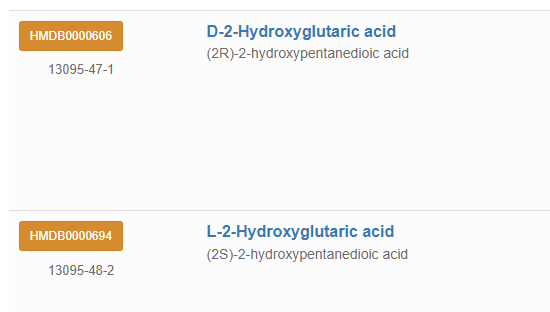
    - D-2-Hydroxyglutaric acid HMDB0000606
    - L-2-Hydroxyglutaric acid HMDB0000694
- d-sedoheptulose-1-7-phosphate
    - HMDB0304323
- 2-deoxyglucose-6-phosphate
- hexose-phosphate
    - Glucose 6-phosphate HMDB0001401




In [78]:
# Unfindable
for i in metab_stat_df[metab_stat_df['pvalue']<=5e-2].index:
    i=i.replace("_pos","")
    i=i.replace("_neg","")
    if len(name_map_df[name_map_df['compound']==i].HMDB.values)==0:
        if len(name_map_df[name_map_df['match']==i].HMDB.values)==0:
            print(i)
    
    # print(name_map_df[name_map_df['compound']==i].HMDB.values[0])

2-deoxyglucose-6-phosphate


#### Result 

In [87]:
metab_stat_df.fillna(0,inplace=True)

In [97]:
for i in metab_stat_df.index:
    if i.endswith("_neg"):
        pair_idx=i[:-4] + '_pos'
        if pair_idx in metab_stat_df.index:
            if abs(metab_stat_df.loc[i, 'log2fc']) < abs(metab_stat_df.loc[pair_idx, 'log2fc']):
                metab_stat_df.drop(i, inplace=True)
            else:
                metab_stat_df.drop(pair_idx, inplace=True)
    elif i.endswith("_pos"):
        i=i[:-4]
for i in metab_stat_df[metab_stat_df['pvalue']<=5e-2].index:
    # print(i)
    if len(name_map_df[name_map_df['compound']==i].HMDB.values)==0:
        if len(name_map_df[name_map_df['match']==i].HMDB.values)==0:
            # print(i)
            continue
        else:
            print(f"{i} {name_map_df[name_map_df['match']==i].HMDB.values[0]} {metab_stat_df.loc[i,'log2fc']}")
            continue
    else:
        # print(f"{name_map_df[name_map_df['compound']==i].compound.values[0]} {name_map_df[name_map_df['compound']==i].HMDB.values[0]} {metab_stat_df.loc[i,'log2fc']}")
            print(f"{name_map_df[name_map_df['compound']==i].HMDB.values[0]} {metab_stat_df.loc[i,'log2fc']}")
    
    # print(name_map_df[name_map_df['compound']==i].HMDB.values[0])

HMDB0000684 -1.0491831335768818
HMDB0001321 -1.1248037659404326
HMDB0001401 -0.891616771816874
HMDB0000294 -0.1568116231448726
HMDB0001316 -0.8749497197779506
HMDB0000929 -0.17292028852801178
HMDB0000133 -0.4706937590340666
HMDB0000807 -0.7263849541010272
cholesterol sulfate HMDB0000653 -0.638537485901657
HMDB0000606 -0.2259683487078767
HMDB0001185 0.24314277485722172
HMDB0001401 -1.7558028066840106
HMDB0000190 -0.3717044296999864
HMDB0000779 -0.665096460442242
HMDB0001248 -0.2541682368113297
HMDB0000229 0.6544676690156781
HMDB0000043 -0.5231037560492127
HMDB0000124 -1.4166268831361222
HMDB0000161 0.284687116280698
HMDB0001397 0.5103263257825768
HMDB0001112 -0.7675960347515856
HMDB0000195 -0.5714140476883123
HMDB0240251 0.46299267960143153
HMDB0000128 0.2219060308497183
HMDB0000099 2.9041445807269692
HMDB0001058 -1.134143158374368
HMDB0001409 0.4305550223565841
HMDB0001367 -0.6557691130770833
HMDB0000271 0.28041357353702867
HMDB0000296 0.28112280579205695
HMDB0000263 -0.767412499244906

In [93]:
metab_stat_df.loc["HMDB0000653",'log2fc']

KeyError: 'HMDB0000653'

In [43]:
sample_indexes=list(set(rna_df.index)&set(sample_df.index))